## Rossmann Store Sales - Insights

Rossmann Store Sales data is available via [Kaggle](https://www.kaggle.com/c/rossmann-store-sales). Data is from a chemist store that has over 6000 stores across Europe. 

In this notebook, I am performing an exploratory analysis of the data rather than feature-exploration. That is, I am looking at what conclusions or insights could be found within this data for a chemist business such as Rossmann. 

_**Note**: I am always looking forward for constructive feedback. If you find a bug or if you think there are some fundamental mistakes, please do let me know. If you think this analysis could be further improved, again please do let me know. Your inputs will be highly appreciated. My contact email: info@theportfoliotrader.com_


I will perform a cursory exploration of the data and will first explore just the train.csv.

In [1]:
%matplotlib inline
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import mpld3
import warnings
import seaborn as sns
sns.set(style='darkgrid')

#
warnings.filterwarnings('ignore')
#mpld3.enable_notebook()
#
# sales data, lets load the data
train = pd.read_csv('../data/rossmann_store_sales/train.csv')
# sort the dates 
train.sort_values(by='Date', ascending=True, inplace=True)
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017208,1115,2,2013-01-01,0,0,0,0,a,1
1016473,379,2,2013-01-01,0,0,0,0,a,1
1016472,378,2,2013-01-01,0,0,0,0,a,1
1016471,377,2,2013-01-01,0,0,0,0,a,1
1016470,376,2,2013-01-01,0,0,0,0,a,1
1016469,375,2,2013-01-01,0,0,0,0,a,1
1016468,374,2,2013-01-01,0,0,0,0,a,1
1016467,373,2,2013-01-01,0,0,0,0,a,1
1016466,372,2,2013-01-01,0,0,0,0,a,1
1016465,371,2,2013-01-01,0,0,0,0,a,1


From the [data description](https://www.kaggle.com/c/rossmann-store-sales/data):
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.  Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

They have missed out DayOfWeek but it is quite obvious what that is.

When we are looking at sales or stores data, specific aspects of the business comes into play. Lets list those aspects (this list is representative/subjective and not exhaustive):
* when are the stores open?
* how does sales/customer trends looks like? are sales & customers data correlated all the time or only sometimes? If sometimes, then what are those days and what was different about those days?
* are there stores that are high/low performers?
* how many promos were organised? what days of the week do promos happen? how many coincide with holidays? do they have any effect on sales/customers?
* what days of the week do stores experience high/low traffic? what was different about those days?


I will now try to address each one of these questions one by one. I may change the question as I see fit or add more as and when I get the light-bulb moment!


#### when are the stores open during the week?

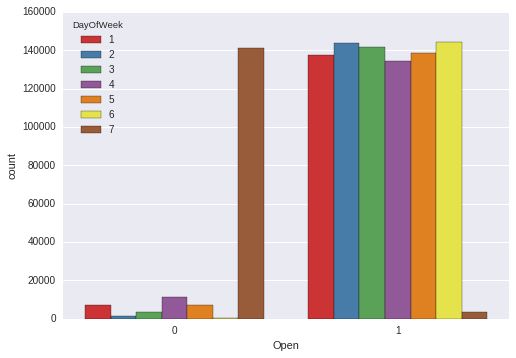

In [2]:
ax = sns.countplot(x='Open', hue='DayOfWeek', data=train, palette='Set1')

*Note: I keep switching between CentOS/Linux and Win10. Weirdly enough there is a TypeError and appears to be a ongoing [issue](https://github.com/mpld3/mpld3/issues/193) on Win10 which does not appear on CentOS/Linux*

From the histogram plot, it is obvious that day-7 has maximum number of 'closed' days. Therefore, there is high probability that day-7 is a Sunday. Therefore,the stores are open generally throughout the week except on Sundays.

#### how does sales/customer trends look like? are sales & customers data correlated all the time or only sometimes? If sometimes, then what are those days and what was different about those days?
#### how many promos were organised? what days of the week do promos happen? how many coincide with holidays? do they have any effect on sales/customers?

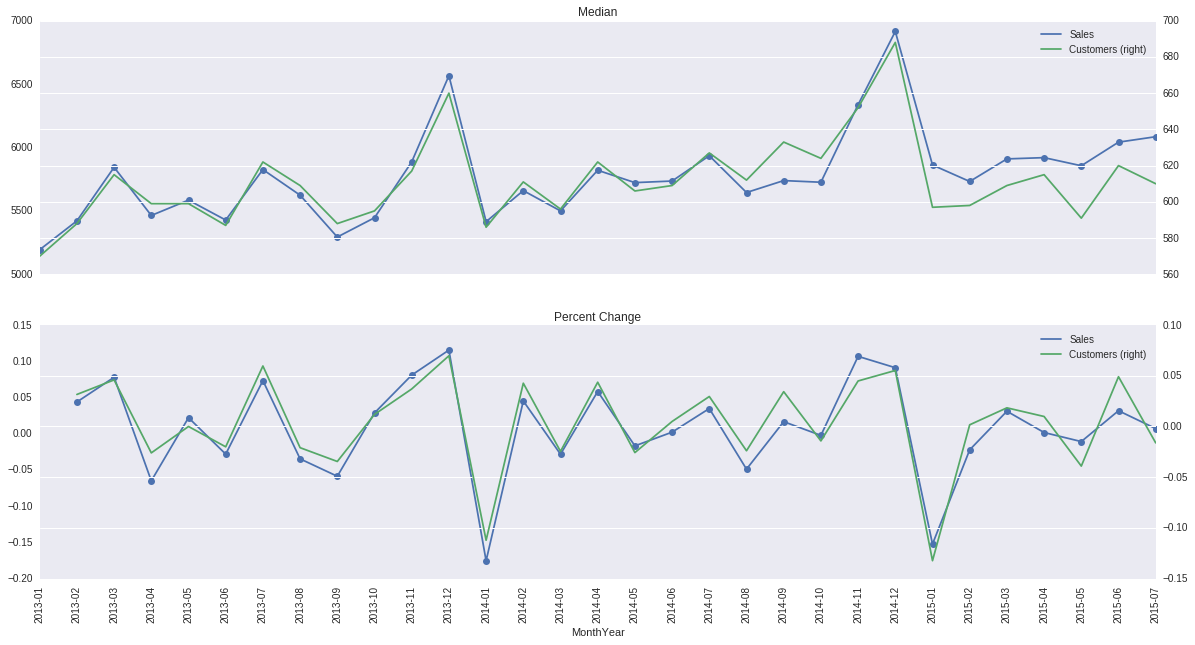

In [3]:
# lets collate sales and customer data on monthly and yearly charts
# split Year-Month-Date to three different columns
train['Month'] = train['Date'].apply(lambda x : int(str(x)[5:7]))
train['Year'] = train['Date'].apply(lambda x : int(str(x)[:4]))
train['MonthYear'] = train['Date'].apply(lambda x : (str(x)[:7]))
                                    
# median sales
median_sales = train.groupby('MonthYear')['Sales'].median()
pct_median_change = train.groupby('MonthYear')['Sales'].median().pct_change()
# median customers
median_cust = train.groupby('MonthYear')['Customers'].median()
pct_median_custchange = train.groupby('MonthYear')['Customers'].median().pct_change()

fig, (axis1, axis2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))
# plot median sales
ax1 = median_sales.plot(legend=True, ax=axis1, marker='o',title="Median")
ax1.set_xticks(range(len(median_sales)))
ax1.set_xticklabels(median_sales.index.tolist(), rotation=90)
#pd.rolling_mean(median_sales, window=7).plot(ax=axis1)
# plot pct change
ax2 = pct_median_change.plot(legend=True, ax=axis2, marker='o',rot=90, title="Percent Change")

# overlay customer data
median_cust.plot(legend=True, ax=axis1, marker='x', secondary_y=True)
pct_median_custchange.plot(legend=True, ax=axis2, marker='x', rot=90, secondary_y=True)

First and formost thing that is obvious from the plot is that sales and customers are highly correlated. Therefore, majority of customers walking through the store are contributing to sales. However, starting in year 2015, customer numbers are diverging slightly away from sales with less customers contributing to more sales. Could this be attributed to increase in cost per item? or customers are being loyal and ringing more sales than before? Customer growth is not evident. Sales and customer numbers appears to spike just before Christmas and fall back down again during the new year. If more customers could be enticed into the store, better sales could be acheived.

Let's plot the sales and customer data with promos, stateholiday and schoolholiday to visualise their behaviour for those days.

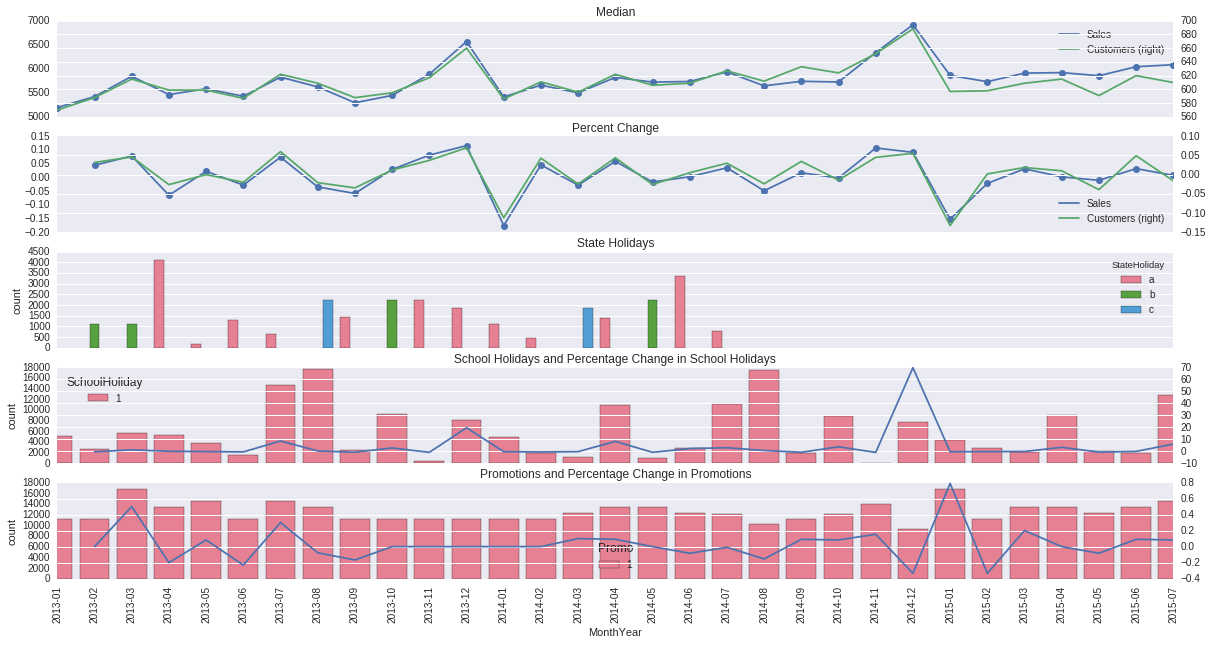

In [4]:
fig, (axis1, axis2, axis3, axis4, axis5) = plt.subplots(5, 1, sharex=True, figsize=(20,10))
# plot median sales
ax1 = median_sales.plot(legend=True, ax=axis1, marker='o',title="Median")
ax1.set_xticks(range(len(median_sales)))
ax1.set_xticklabels(median_sales.index.tolist(), rotation=90)
#pd.rolling_mean(median_sales, window=7).plot(ax=axis1)
# plot pct change
ax2 = pct_median_change.plot(legend=True, ax=axis2, marker='o',rot=90, title="Percent Change")

# overlay customer data
median_cust.plot(legend=True, ax=axis1, marker='x', secondary_y=True)
pct_median_custchange.plot(legend=True, ax=axis2, marker='x', rot=90, secondary_y=True)

# stateholiday overlay
# StateHoliday has a mixture of "O", 0 and "0", replace these with "O"
train.StateHoliday.replace(["O",0,"0"],['O','O','O'], inplace=True)
ax3 = sns.countplot(x='MonthYear', hue='StateHoliday', data=train[train['StateHoliday']!='O'], palette='husl', ax=axis3)
tmp = ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
tmp = ax3.set_title('State Holidays')
#schoolholiday overlay
ax4 = sns.countplot(x='MonthYear', hue='SchoolHoliday', data=train[train['SchoolHoliday']!=0], palette='husl', ax=axis4)
subs = train[train['SchoolHoliday']!=0]
cntchange = subs.groupby('MonthYear')['SchoolHoliday'].count().pct_change()
cntchange.plot(ax=axis4, marker='x', secondary_y=True)
tmp = ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
tmp = ax4.set_title('School Holidays and Percentage Change in School Holidays')
#promotions overlay
ax5 = sns.countplot(x='MonthYear', hue='Promo', data=train[train["Promo"]!=0], palette='husl', ax=axis5)
subs = train[train['Promo']!=0]
cntchange = subs.groupby('MonthYear')['Promo'].count().pct_change()
cntchange.plot(ax=axis5, marker='x', secondary_y=True)
tmp = ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
tmp = ax5.set_title('Promotions and Percentage Change in Promotions')

#### State Holidays
I think there is something amiss about the "StateHoliday" data. From August 2014, there appears to be no StateHoliday at all, which is highly unlikely, most likely it is the case of "missing data". That can be fixed by filling the values using previous years StateHolidays, as StateHolidays rarely change.

#### School Holidays
SchoolHolidays appears to be seasonal, with July-August being the highest, may be July-August is the summer vacation time. Interesting observation is that there are minimal/least school holidays in November i.e. before Christmas vacation. Another observation is the decreasing trend of school holidays reaching a minimum point just before the vacation starts. And on the other hand, after the vacation when the school restarts there is a increasing trend of school holidays with an abrupt drop after which the decreasing trend takes on.  This abrupt drop might be the school restart after a mid-term break.

#### Promotions
When you look at the number of promotions being held, it appears that every month there were promotions at various stores. An interesting observation is that there is a massive drop in sales/customers in January, 2014 and there were no promotions subsequent to these drop in numbers which clearly suggests that the management were unable to predict this drop in numbers. If they had predicted the drop they would have organised more promotions to lure in the customers. This is evident from the January, 2015 , where they have organised more promotions in January, 2015 learning from their mistakes from 2014. Subsequently, there appears to be more sales, albeit small change compared to Jan-Feb 2014, with same number of customers. They have organised more promotions during School holidays but it has not had much positive impact on sales or customer numbers. Again, another interesting observation is sales always has an increasing uptrend during the days when the schools are in session. Either kids are falling sick very often during School sessions or many more stores are open during school sessions?


#### which stores are high/low performers?
#### what days of the week do stores experience high/low traffic? what was different about those days?

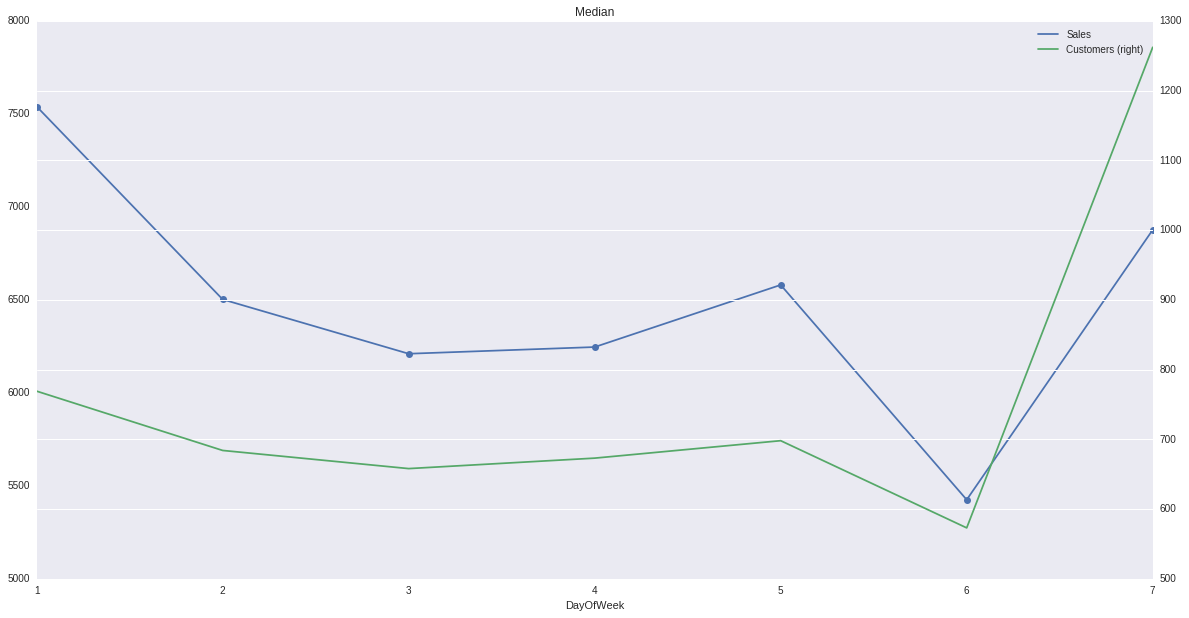

In [5]:
# group sales/customer data by weekday
day = train[(train['Open']!=0)]
sales_day = day.groupby('DayOfWeek')['Sales'].median()
cust_day = day.groupby('DayOfWeek')['Customers'].median()
#
fig, (axis1) = plt.subplots(1,1, sharex=True, figsize=(20,10))
# plot median sales
ax1 = sales_day.plot(legend=True, ax=axis1, marker='o',title="Median")
ax1.set_xticks(sales_day.index)
tmp = ax1.set_xticklabels(sales_day.index.tolist(), rotation=90)
# overlay customer data
cust_day.plot(legend=True, ax=axis1, marker='x', secondary_y=True)


That is a very interesting plot. Let's assume day-1 is Monday and day-7 is Sunday. Throughout the week until Friday, less customers are ringing in more sales. On Saturday, both the number of sales and customers drop to the lowest and spike again on Sunday. However, only on Sunday there is an opposite behaviour i.e. more customers are ringing in less sales, in other words there is more customer traffic but less sales. There is only one conclusion from this plot, the customers who walk into the store during the week are serious customers who will most likely make a sale whereas customers walking in on Sunday appear to be distracted/disinterested/window-shopping! One area of improvement would be to look at converting the customer numbers to sales on the weekend, may be targeted promotions, etc.

Let's look at the performance of stores. 

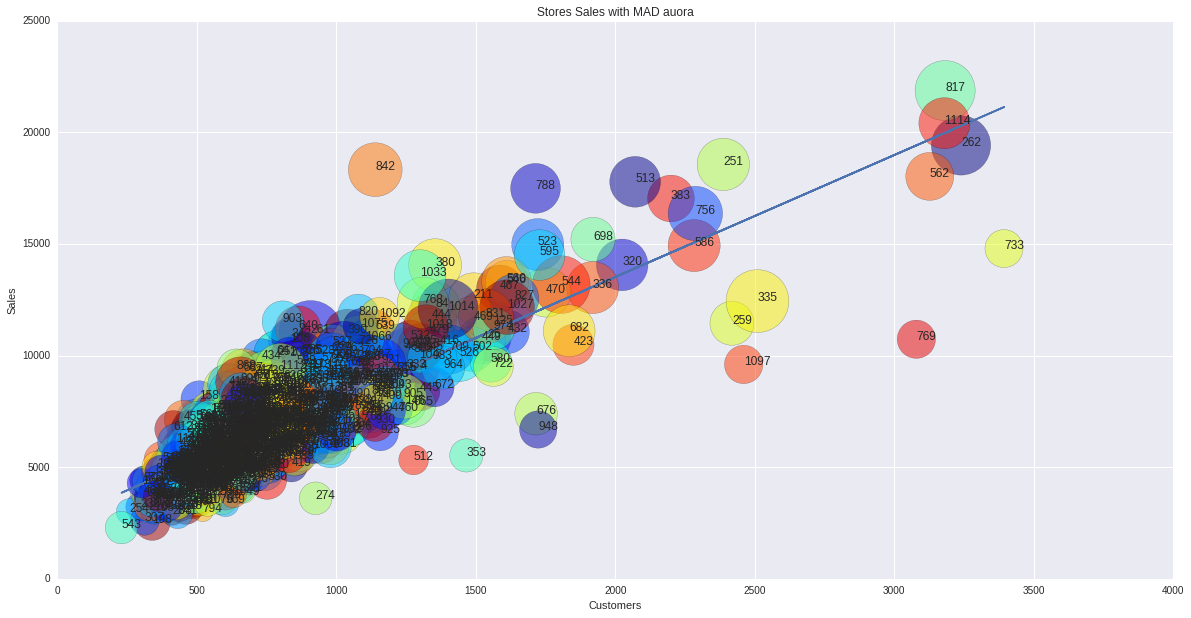

In [6]:
subs = train[train['Open']!=0] # select all data where the stores were open
# gather median and MAD for each store
sales_perstore = subs.groupby('Store')['Sales'].median()
mad_sales_perstore = subs.groupby('Store')['Sales'].mad()
cust_perstore = subs.groupby('Store')['Customers'].median()
mad_cust_perstore = subs.groupby('Store')['Customers'].mad()
# sales to customer ratio
sales_cust_ratio = sales_perstore/cust_perstore
mad_sales_cust_ratio = mad_sales_perstore/cust_perstore  # MAD for sales_cust_ratio is ratio between MAD sales and total customers
# plot scatter plot of sales vs customers
fig, (axis1) = plt.subplots(1,1, sharex=True,figsize=(20,10))
colors = np.random.rand(len(sales_perstore))
axis1.scatter(cust_perstore, sales_perstore, s=mad_sales_perstore, c=colors, cmap='jet', alpha=0.5)
axis1.set_xlabel('Customers')
axis1.set_ylabel('Sales')
axis1.set_title('Stores Sales with MAD auora')
for store in sales_perstore.index:
    #print('{}'.format(sales_perstore[i]))
    axis1.annotate(store, (cust_perstore[store], sales_perstore[store]))
# plot a fitted line
linefit = np.poly1d(np.polyfit(cust_perstore, sales_perstore, 1))(cust_perstore);
axis1.plot(cust_perstore, linefit)

In the scatter plot above, we have plotted sales vs customers for each store. Each store is represented by its median sales and customers and the auora around each store is the extent of its mean-absolute-deviation.  The plot suggests that the sales and customers have a linear relationship i.e. increasing customer numbers will increase sales and vice-versa. A few stores have high-traffic, e.g.: 817, 1114, 733, 262 and 562. Majority of the stores appear to be on the lower end of the customer scale. 

How do we determine the performance of a store? A fairly straightforward approach is via profits .i.e. higher the profits, better the performance. Profits are directly related to sales, therefore more sales will result in more profits. What are sales dependent on? Customers. Therefore, logically more customers visiting a store should result in more sales. But the real world does not work that way. Lots of customers just browse or window-shop and not contribute to sale. Therefore, in my opinion, the best performance measure for a store should be **sales per customer** or ratio of sales to customer. For example, if 10 customers spend a total of $\$$10, then sale to customers ratio is $\$$1 per customer. If you increase this ratio, then the store's profit will increase as a result and vice versa. Therefore, if you somehow manage to increase from $\$$1 per customer to $\$$2 per customer, or increase the customer numbers at the $\$$1 per customer, your store's profitability also increases.  

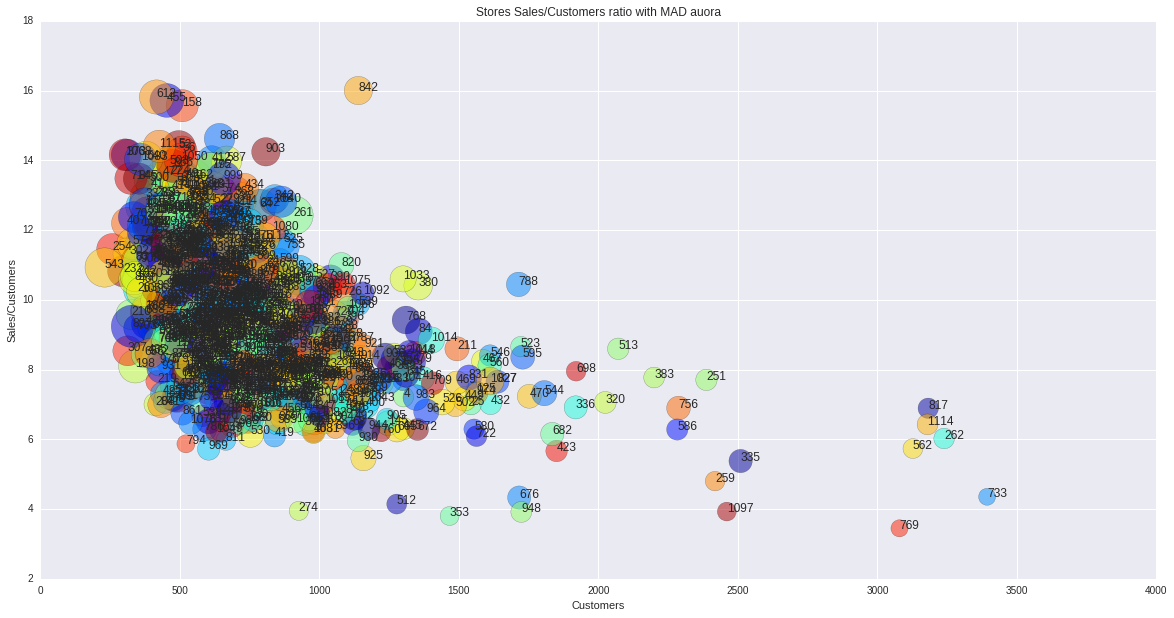

In [7]:
subs = train[train['Open']!=0] # select all data where the stores were open
# sales to customer ratio
sales_cust_ratio = train['Sales']/train['Customers']  # will result in NaN's, look out
train['Sales-Customers'] = pd.Series(sales_cust_ratio, index=train.index)
subs_1 = train[train['Open']!=0] # select all data where the stores were open
subs = subs_1[subs_1['Sales-Customers'].notnull()] # remove NANs
# gather median and MAD for each store
SC_perstore = subs.groupby('Store')['Sales-Customers'].median()
mad_SC_perstore = subs.groupby('Store')['Sales-Customers'].mad()
cust_perstore = subs.groupby('Store')['Customers'].median()
mad_cust_perstore = subs.groupby('Store')['Customers'].mad()
# scatter plot of sales/customers vs customers
sns.set(font_scale=1)
fig, (axis1) = plt.subplots(1,1, sharex=True,figsize=(20,10))
colors = np.random.rand(len(SC_perstore))
axis1.scatter(cust_perstore, SC_perstore, s=mad_SC_perstore*1000, c=colors, cmap='jet', alpha=0.5) # multiplying "size" by 1000 to make the extent visible
axis1.set_xlabel('Customers')
axis1.set_ylabel('Sales/Customers')
axis1.set_title('Stores Sales/Customers ratio with MAD auora')
for store in SC_perstore.index:
    #print('{}'.format(sales_perstore[i]))
    axis1.annotate(store, (cust_perstore[store], SC_perstore[store]))


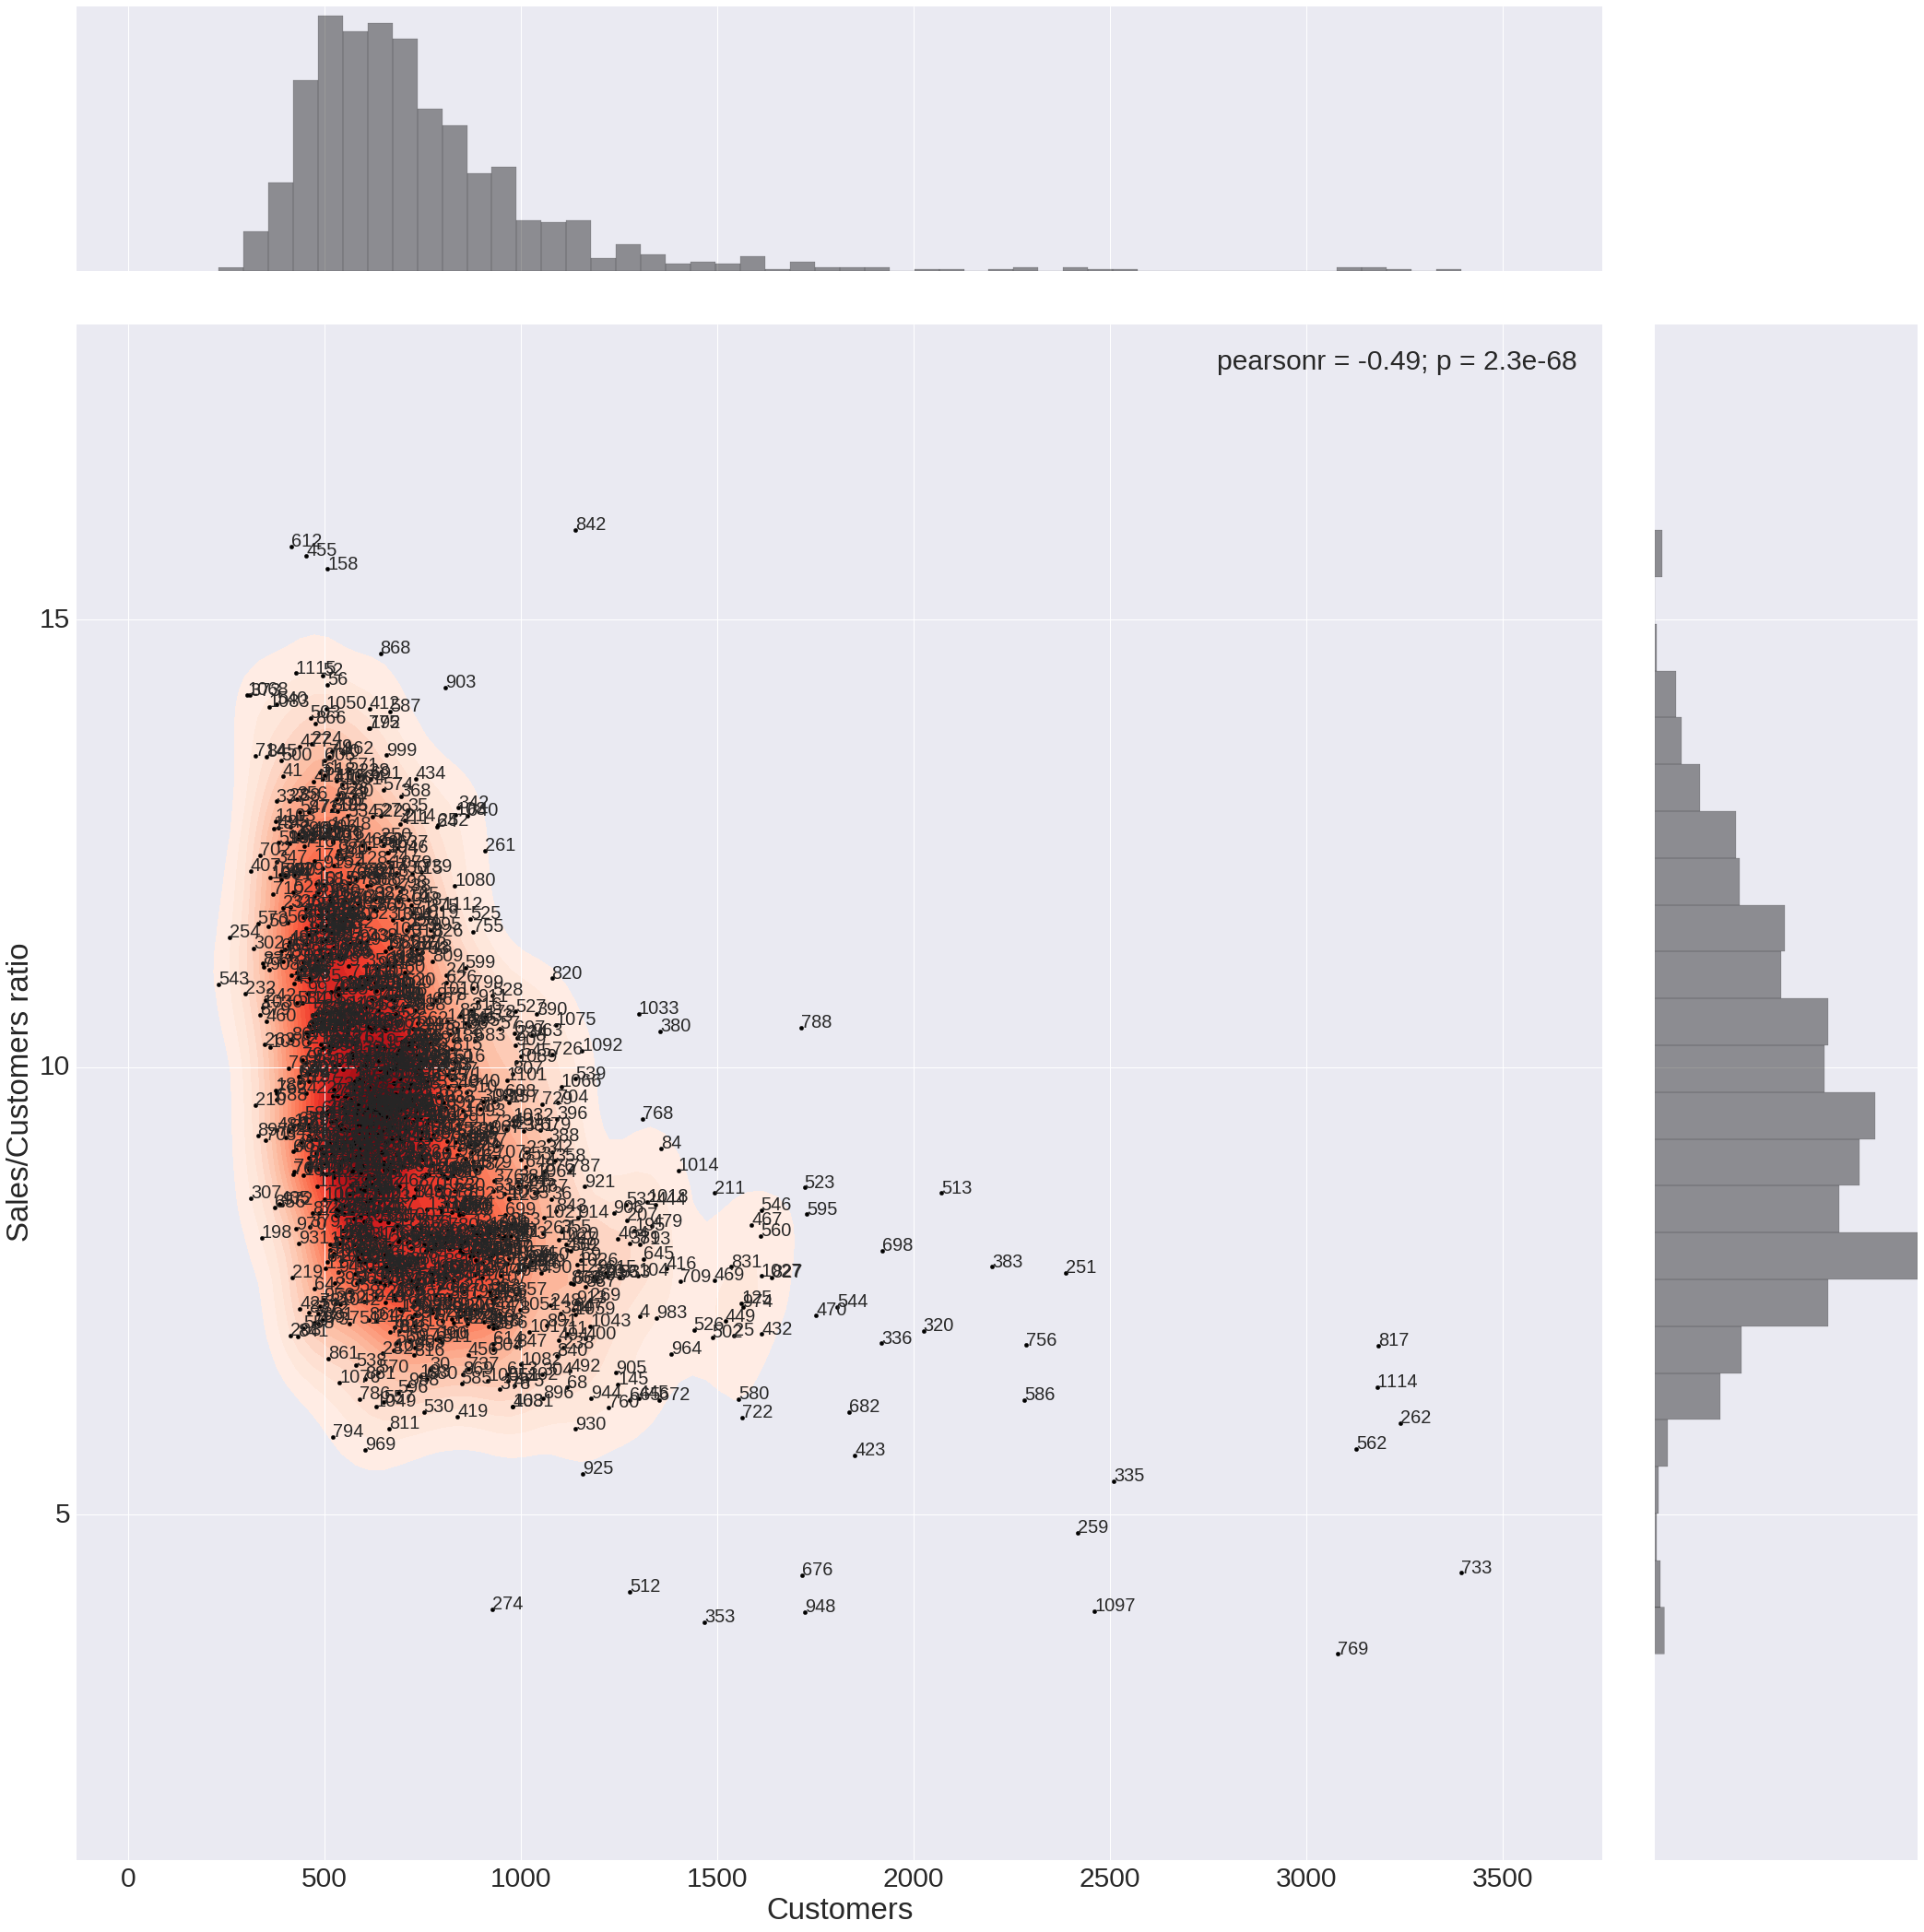

In [8]:
# create a temp dataframe
df = pd.DataFrame({'Sales/Customers ratio': SC_perstore, 'Customers':cust_perstore, 
                   'Sales/Customers-MAD': mad_SC_perstore, 'Store':SC_perstore.index})
# create a jointplot and add an joint density estimate
sns.set(font_scale=3)
ax1 = sns.jointplot(x='Customers', y='Sales/Customers ratio', data=df, 
                                   color='k', size=30)
ax1.plot_joint(sns.kdeplot, zorder=0, n_levels=30, cmap="Reds", shade=True, shade_lowest=False)

# annotate every datapoint with StoreID
for store in SC_perstore.index:
    #print('{}'.format(sales_perstore[i]))
    ax1.ax_joint.annotate(store, (df['Customers'][store], df['Sales/Customers ratio'][store]), fontsize=20)


Now, lets try and pick out high/low performers. One way of doing this is via anamoly/outlier detection. Anamolous behaviour is a behaviour that is out of normal. Kernel density estimation in the above plot shows that majority of the stores have a `certain` behaviour, in terms of sales to customers ratio (stores within the red outline). If we assume that this is expected behaviour, then all the stores that lie outside of the red region are anamolous/outliers. Now, lets extract those stores.


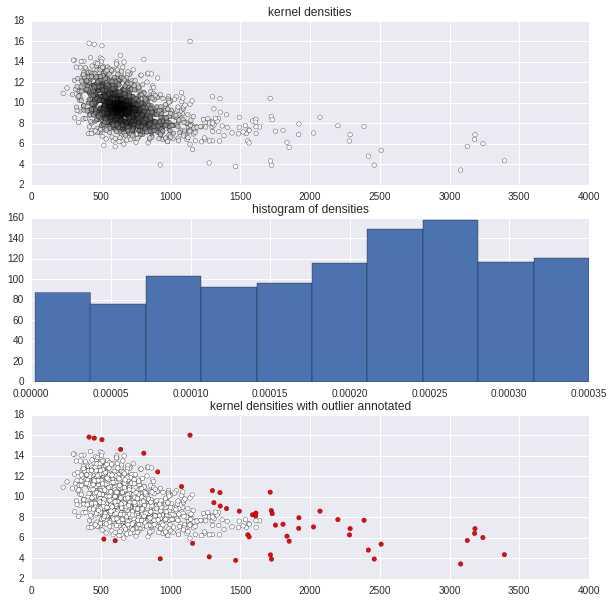

In [9]:
# calculate kernel densities
from scipy import stats
values = np.vstack([cust_perstore.ravel(), SC_perstore.ravel()])
kde = stats.gaussian_kde(values)
density = kde(values)

# plot to confirm
sns.set(font_scale=1)
fig, (axis1,axis2, axis3) = plt.subplots(3,1, figsize=(10,10))
x,y = values
axis1.scatter(x,y, c=density)
axis1.set_title('kernel densities')
n, bins, patches = axis2.hist(density, 10)
axis2.set_title('histogram of densities')

#lowest threshold
thres = bins[1]-((bins[1] - bins[0])/2)

# plot the outlier points using the threshold
use_colors = {True:'red', False:'white'}
axis3.scatter(x,y, c = [use_colors[x <= thres] for x in density])
axis3.set_title('kernel densities with outlier annotated')
plt.show()

# outliers
outlier_stores = density < thres
df['Outlier'] = pd.Series(outlier_stores, index=df.index)

## Lets create the joint plot again and annotate only the outliers
## create a jointplot and add an joint density estimate
#sns.set(font_scale=3)
#ax1 = sns.jointplot(x='Customers', y='Sales/Customers ratio', data=df, 
#                                   color='k', size=30)
#ax1.plot_joint(sns.kdeplot, zorder=0, n_levels=30, cmap="Blues", shade=True, shade_lowest=False)
## annotate only outlier datapoint with StoreID
#for i, store in enumerate(SC_perstore.index):
#    #print('{}'.format(sales_perstore[i]))
#    if(outlier_stores[i]):
#        ax1.ax_joint.annotate(store, (df['Customers'][store], df['Sales/Customers ratio'][store]), fontsize=30, color='k')


We have now identified the outliers in the data. The outlier stores are the ones that deviate from the normal behaviour, these could include high performing and low performing stores. The only way to distinguish between a high and low performing store is via the performance measure. In this analysis I am using sales to customer ratio as a performance measure. Lets apply some threshold to the outlier and further classify high and low performing stores.

Someone might question the assumption of `normal` behaviour in this case with an argument that there are stores in the `normal` region (Blue) that appear to have low sales per customer. For them, I would like to present a simple analogy, not every finger on your hands are alike, not all eggs in the basket are alike. Similarly, as a business or a store, there will be variations in the performance pattern. By identifying a group that encompasses the majority of the data points, we can consider that to be the `normal` behaviour. Now, if you change any parameters that affect the `normal` behaviour the performance of the entire group should move accordingly. This group could also be considered as a `critical mass`, useful for forecasting stocks, sales, logistics, resources etc. 

High performers:  $15.64094345825115 - sales/customer,  575.0 - customers
Low performers:  $6.3597060203615445 - sales/customer,  1842.25 - customers
Normal performers:  $9.344202898550725 - sales/customer,  661.0 - customers


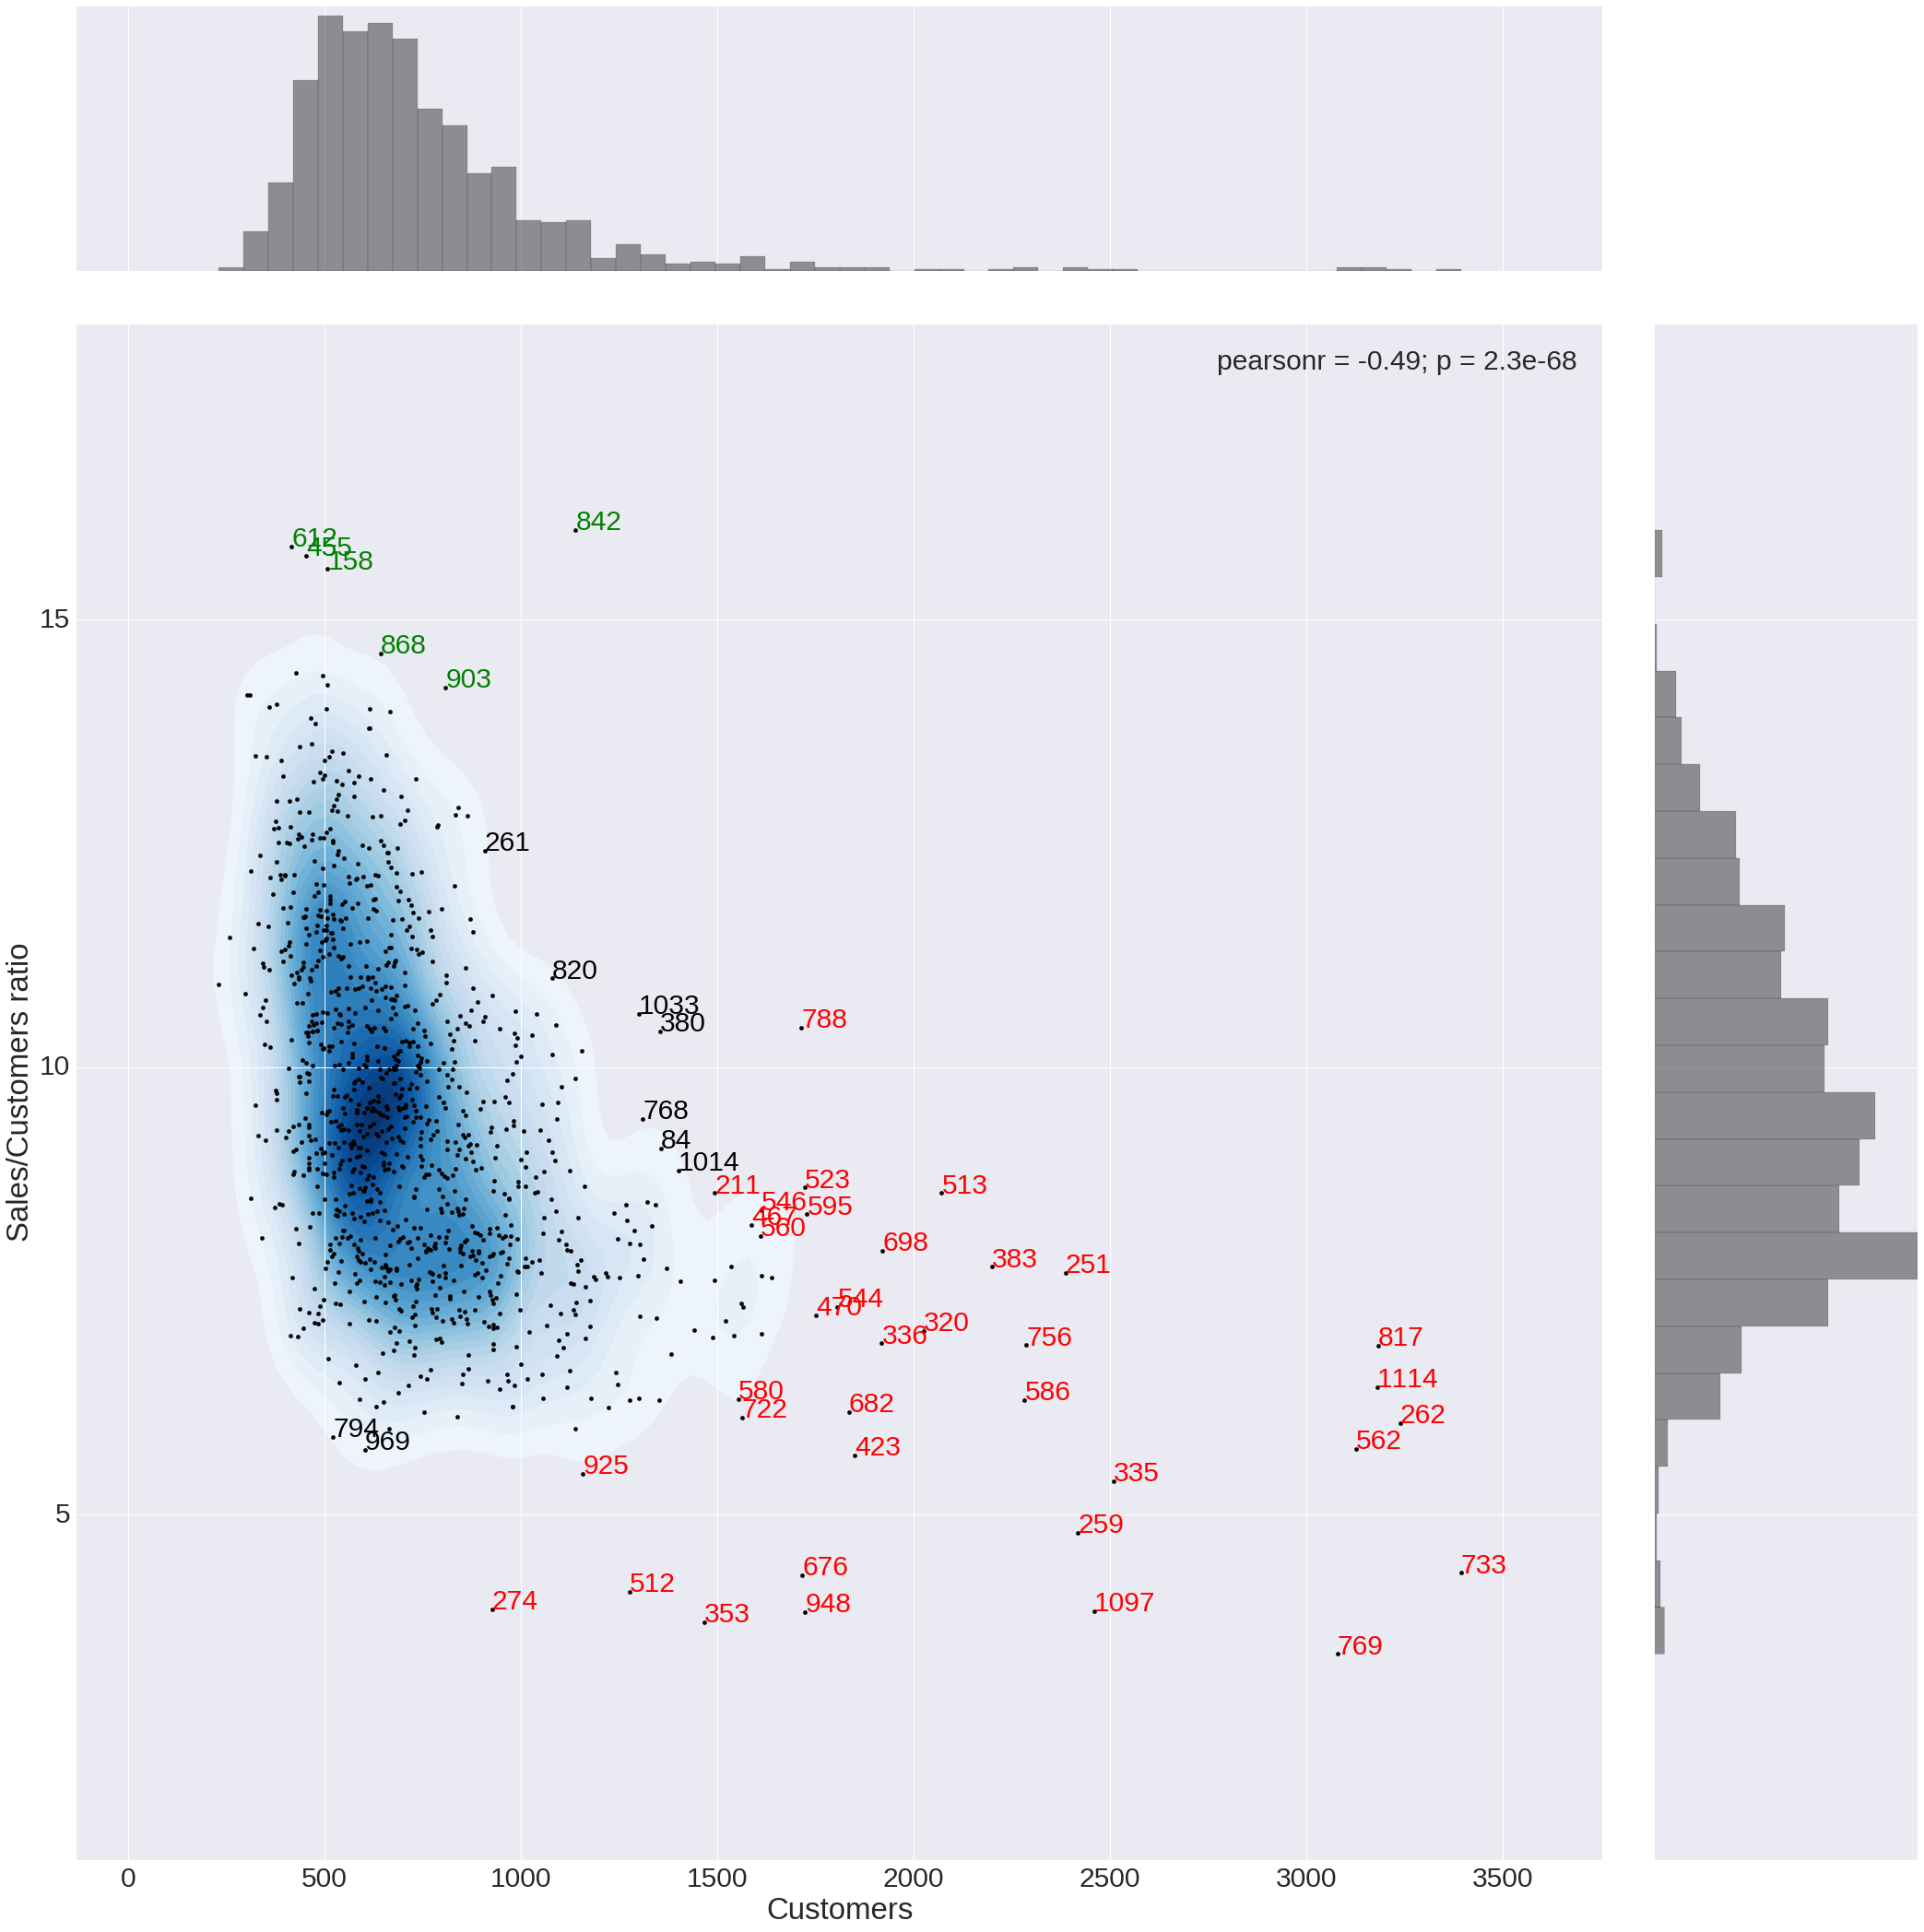

In [10]:
# Lets create the joint plot again and annotate only the outliers
# create a jointplot and add an joint density estimate
sns.set(font_scale=3)
ax1 = sns.jointplot(x='Customers', y='Sales/Customers ratio', data=df, 
                                   color='k', size=30)
ax1.plot_joint(sns.kdeplot, zorder=0, n_levels=30, cmap="Blues", shade=True, shade_lowest=False)

#
sales_cust_ratio_threshold = [SC_perstore.mean() - 2*SC_perstore.std(), SC_perstore.mean() + 2*SC_perstore.std()] 
cust_threshold = [cust_perstore.mean() - 2*cust_perstore.std(), cust_perstore.mean() + 2*cust_perstore.std()]
# annotate only outlier datapoint with StoreID
outlier_annotate = ['n' for x in range(len(outlier_stores))] # creaet a array full of "normal(n)"
for i, store in enumerate(SC_perstore.index):
    #print('{}'.format(sales_perstore[i]))
    if(outlier_stores[i]):
        # color red if below threshold ELSE color green is above threshold
        if(df['Sales/Customers ratio'][store] <= sales_cust_ratio_threshold[0]
                or df['Customers'][store] >= cust_threshold[1]):
            outlier_annotate[i] = 'l' # low-performer
            ax1.ax_joint.annotate(store, (df['Customers'][store], df['Sales/Customers ratio'][store]), fontsize=30, color='r')
        
        elif (df['Sales/Customers ratio'][store] >= sales_cust_ratio_threshold[1]
                or df['Customers'][store] < cust_threshold[0]):
            outlier_annotate[i] = 'h' # high performer
            ax1.ax_joint.annotate(store, (df['Customers'][store], df['Sales/Customers ratio'][store]), fontsize=30, color='g')
        
        else:
            #outlier_annotate[i] = 'm' # medium performer
            ax1.ax_joint.annotate(store, (df['Customers'][store], df['Sales/Customers ratio'][store]), fontsize=30, color='k')
               
#
df['Annotation'] = pd.Series(outlier_annotate, index=df.index)
#

# performance measure
hp = df[df['Annotation'] == 'h']['Sales/Customers ratio'].median()
hc = df[df['Annotation'] == 'h']['Customers'].median()
lp = df[df['Annotation'] == 'l']['Sales/Customers ratio'].median()
lc = df[df['Annotation'] == 'l']['Customers'].median()
nop = df[df['Annotation'] == 'n']['Sales/Customers ratio'].median()
nc = df[df['Annotation'] == 'n']['Customers'].median()
print('High performers:  ${} - sales/customer,  {} - customers'.format(hp, hc))
print('Low performers:  ${} - sales/customer,  {} - customers'.format(lp, lc))
print('Normal performers:  ${} - sales/customer,  {} - customers'.format(nop, nc))

By thresholding the outlier stores, I have classified high performing (Green) and low performing (Red) stores. High performing stores have higher sales per customer compared to low performing stores. As this analysis was performed on long term data, we can conclude that for various reasons(unknown) the low-performing stores have not been able to successful convert their foot-traffic or customers into sales.

Within the confines of the data provided, lets try and analyse the characteristics of stores that are either high or low performers. In my opinion, characteristics such as Promo, StoreType, Assortment and CompetitionDistance might have a part to play in contributing to a store being a high/low performer.

#### Effect of StoreType & Assortment on stores performance:

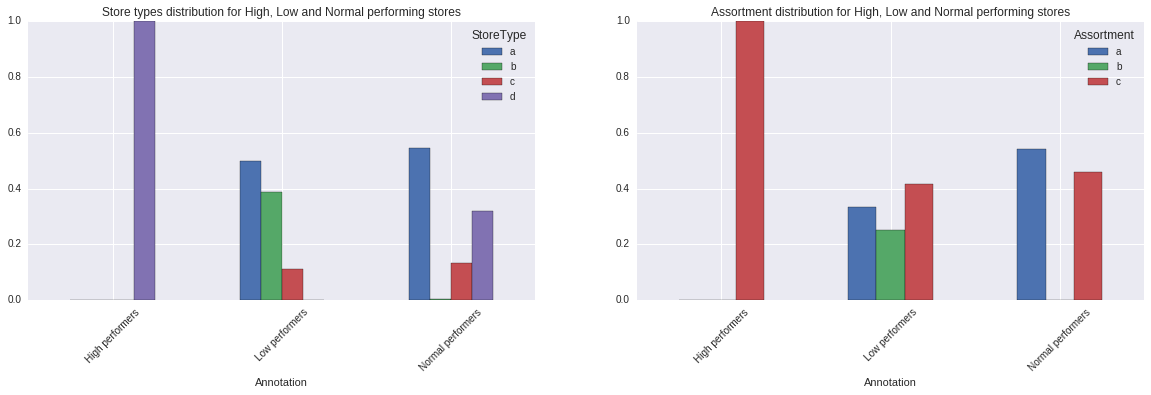

In [11]:
# load stores.csv
stores = pd.read_csv('../data/rossmann_store_sales/store.csv')

# merge previous stores data with new stores data
stores_update = stores.merge(df, how='outer', on='Store')

# extract stores-data for all three categories of performers
#high_performers = stores[stores['Store'].isin(high_stores)]
#low_stores = df[df['Annotation'] == 'l']['Store']
#low_performers = stores[stores['Store'].isin(low_stores)]
#normal_stores = df[df['Annotation'] == 'n']['Store']
#normal_performers = stores[stores['Store'].isin(normal_stores)]

# Storetype - distribution (normalised histograms) across High, Low and Normal performers 
#(creating histograms of category using another category as bins (not numeric) is a bit problematic so a long-winded approach)
# refer: http://themrmax.github.io/2015/11/13/grouped-histograms-for-categorical-data-in-pandas.html
storetype = stores_update.groupby('Annotation')['StoreType'].value_counts().sort_index()
s = storetype.unstack()
s[s.isnull()]=0
# for each annotation calculate normalised value_counts
for st in s.index:
    s.ix[st]  = s.ix[st]/s.ix[st].sum()
    
s[s.isnull()]=0  # convert all NAN to ZERO  
storetype = s


# Assortment - distribution (normalised histogram) across High, Low and Normal performers
assort = stores_update.groupby('Annotation')['Assortment'].value_counts().sort_index()
s = assort.unstack()
s[s.isnull()]=0
# for each annotation calculate normalised value_counts
for st in s.index:
    s.ix[st]  = s.ix[st]/s.ix[st].sum()
s[s.isnull()]=0  # convert all NAN to ZERO  
assort = s

# plot
sns.set(font_scale=1)
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(20,5))
ax = storetype.plot(kind='bar', rot=45, ax=axis1)
tmp = ax.set_xticklabels(['High performers', 'Low performers', 'Normal performers'])
tmp = ax.set_title('Store types distribution for High, Low and Normal performing stores')
ax1 = assort.plot(kind='bar', rot=45, ax=axis2)
tmp = ax1.set_xticklabels(['High performers', 'Low performers', 'Normal performers'])
tmp = ax1.set_title('Assortment distribution for High, Low and Normal performing stores')



Looking at the plots above, we can compare the different characteristics of High, Low and Normal performing stores. When you consider Low performing stores in comparison with other two, there are two important distinctions. Low performing stores do not have StoreType = "d" but have StoreType = "b" and are the only stores that stock Assortment = "b" along with the other two types of Assortments. High performing stores on the other hand are all StoreType = "d" and stock only Assortment = "c". This is a clear indication that StoreType = "d" stocking Assortment = "c" correlates to acheiving high performance. And StoreType = "b" and Assortment = "b" appear to have negative correlation to acheiving high performance.  May be the lack of StoreType = "b" and Assortment = "b" has pushed stores to Normal performance.

#### Effect of Competition Distance on stores performance

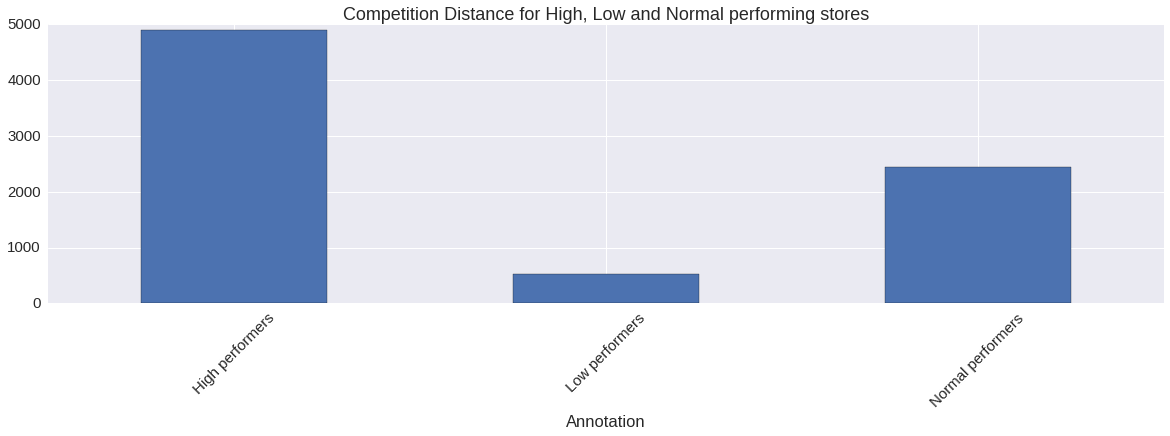

In [12]:
# Competition Distance - across High, Low and Normal performers
compdist = stores_update.groupby('Annotation')['CompetitionDistance'].median()
# plot
sns.set(font_scale=1.5)
fig, (axis1) = plt.subplots(1,1, figsize=(20,5))
ax = compdist.plot(kind='bar', rot=45, ax=axis1)
tmp = ax.set_xticklabels(['High performers', 'Low performers', 'Normal performers'])
tmp = ax.set_title('Competition Distance for High, Low and Normal performing stores')

High performing stores have little competition nearby where as on the other hand low performing stores have competition very nearby. 

Therefore, a combination of factors including StoreType, Assortment and CompetitionDistance have contributed to certain stores being low performers. I have not explored the impact on ComptetionOpenSince and Promo2 factors on stores performance and sales performance in general.

#### Plan of action:
In my opinion, general plan of action to improve sales and customer traffic will obviously help. However more nuanced approach is required, addressing shortcomings of these three categories of performers individually will deliver a big boost to sales numbers. In particular,
* **High Performers**: Customers numbers are less, create campaigns and promotions to drive up customer numbers. Importance should be given to increase customer traffic via other means instead of directly offering discounts. Do not make drastic changes to StoreType or Assortments
* **Low Performers**: Sales per customers is very less compared to customer traffic. Lots of customers are visiting but very few are ringing sales therefore targeted campaigns and promotions must be devised that entice the visiting customers to make a sale. Importance should be given to increasing sales via offering discounts and pricing competitively with nearby competition in mind. Make changes to StoreType and Assortment, customer traffice might be a floating population and you need to keep fiddling with StoreType and Assortment to entice customers.
* **Normal Performers**: A combination of strategies being used to improve high and low performing stores should be employed here albeit at a very slower or less accelerated pace.


In conclusion to whether competition distance have an effect on performance of a store, my answer is, yes and I have showcased the same above. My analysis is in stark contrast to [Christian Thiele's](https://www.kaggle.com/thie1e/rossmann-store-sales/exploratory-analysis-rossmann) where he states 
> The effect of the distance to the next competitor is counterintuitive. Lower distance to the next competitor implies (slightly, possibly not significantly) higher sales.

In his work, although it is not explicitly stated, considers sales as a direct performance measure of a store. In my work I consider sales per customer as a performance measure and clearly shows the impact on sales per customer when a competition exists nearby.



#### What was the impact on  store's performance when competiting stores opened nearby?

The impact of competition opening nearby would be seen in the stores performance in and around the competition opening dates. Competition opening data has resolution of month therefore we will have to look at preceeding and succeeding months sales/customers data along with the actual month the competition opened to determine its impact.


In [13]:
# year and month when the competition opened
year = stores_update['CompetitionOpenSinceYear']
month = stores_update['CompetitionOpenSinceMonth']

# there are many NANs, remove them
stores_notnull = year.notnull() & month.notnull()
st = stores_update[stores_notnull]['Store']
stores_update['CompOpen'] = stores_update[stores_notnull]['CompetitionOpenSinceYear'].astype(int).astype(str).str.cat(stores_update[stores_notnull]['CompetitionOpenSinceMonth'].astype(int).astype(str).str.zfill(2), sep='-')

# extract data for stores with data for competition start dates
stores_withdata = train[train['Store'].isin(st)]
subs =[]
subs = stores_withdata[stores_withdata['Open'] != 0] # select all stores that were open


def get_periods(store):
    ''' For a given "store" extract competition open dates (try pd.Period as an error/null/nan-check)
    '''
    comp = stores_update[stores_update['Store']==store]['CompOpen'].tolist()[0]
    try:
        per = pd.Period(comp)
        return comp
    
    except:
        return None

def get_CompetitionOpenData_forStore(stores_data, store, buffer=1):
    ''' For a given "store", extract its relevant data based on competition dates
    '''
    # length of total period
    len_period = len(range(0,(2*buffer+1)))
    # get competition open date
    comp = get_periods(store)
    if comp is not None:
        # extract store data and return only the values (without the index)
        out = stores_data.loc[store, pd.Period(comp)-buffer:pd.Period(comp)+buffer].values
        # for some stores, data may not exist for the entire period, ignore those
        if out.size == len_period:
            #return out.ravel().tolist() # out is ndarray, need ravel to convert to 1-D array
            #print(store, len_period, len(out), out)
            return out.tolist()
        
        else:
            return None
        
    else:
        return None 
    
    
def get_data_forCompetitionOpen(selected_stores, attribute='Sales', buffer=1):
    ''' For a given attribute and buffer, extract data for all stores from selected_stores
    '''
    # get median sales for each month for each store
    s = subs.groupby(['Store','MonthYear'])[attribute].median()
    # create timeseries index
    per = pd.DatetimeIndex(s.index.get_level_values('MonthYear'), format='%Y-%m').to_period('m')
    # re-index the multiindex using Store and "per"
    #s.index.set_levels(per, level='MonthYear', inplace=True)
    new_index = list(zip(s.index.get_level_values('Store'), per))
    s.index = pd.MultiIndex.from_tuples(new_index, names=('Store', 'MonthYear'))
    
    # extract data for all stores in and around their respective competition dates
    #data = pd.concat([ get_CompetitionOpenData_forStore(s, store, 1) for store in stores_update['Store'][0:6]]) # to produce a indexed dataframe of extracted data
    #data = [get_CompetitionOpenData_forStore(s, store, buffer) for store in stores_update['Store'][0:6]]
    data = [get_CompetitionOpenData_forStore(s, store, buffer) for store in stores_update['Store']]
    # remove None from list
    data = [x for x in data if x is not None]
    return np.array(data)


buffer = 3
# Sales for competitionOpen
dataSales = get_data_forCompetitionOpen(selected_stores=subs, attribute='Sales', buffer=buffer)
# Customers for competitionOpen
dataCust = get_data_forCompetitionOpen(selected_stores=subs, attribute='Customers', buffer=buffer)

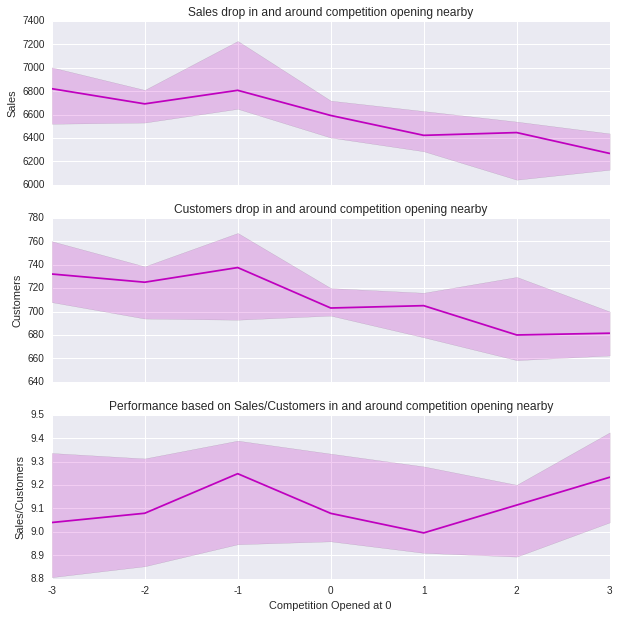

In [14]:
#dataCust = dataCust/dataCust.max(axis=1)
# plot
sns.set(font_scale=1)
fig, (axis1, axis2, axis3) = plt.subplots(3,1, sharex=True, figsize=(10,10))
ax1 = sns.tsplot(data=dataSales, ax=axis1, estimator=np.median, color='m')
ax1.set_xticks(range(0,2*buffer+1))
ax1.set_xticklabels(range(-buffer,buffer+1))
ax1.set_ylabel('Sales')
ax1.set_title('Sales drop in and around competition opening nearby')
ax2 = sns.tsplot(data=dataCust, ax=axis2, estimator=np.median,color='m')
ax2.set_title('Customers drop in and around competition opening nearby')
ax2.set_ylabel('Customers')
ax3 = sns.tsplot(data=dataSales/dataCust, ax=axis3, estimator=np.median, color='m')
ax3.set_xlabel('Competition Opened at 0')
ax3.set_ylabel('Sales/Customers')
ax3.set_title('Performance based on Sales/Customers in and around competition opening nearby')

From the above plots, it is quite evident that there has been a negative impact on Sales and Customers due to a competition opening nearby. It is also quite interesting to note that around the time competition opened nearby, sales per customer fell although by negligible amount. Sales and Customers do not appear to have recovered.


### Yearly plot

Let's look at Sales and Customers data on a yearly basis.

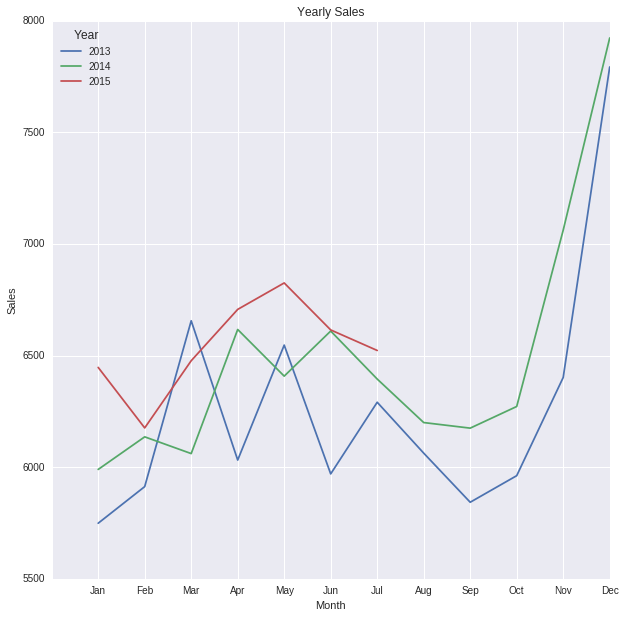

In [15]:
import calendar
# select all stores that were open
subs = train[train['Open']!=0]
# groupby Year and Month
selected_sales = subs.groupby(['Year', 'Month'])['Sales'].median()
selected_cust = subs.groupby(['Year', 'Month'])['Customers'].median()

# plot
fig, (axis1) = plt.subplots(1,1, figsize=(10,10))
selected_sales.unstack().T.plot(ax=axis1)
tmp = axis1.set_title("Yearly Sales")
tmp = axis1.set_ylabel("Sales")
tmp = axis1.set_xticks(range(0,13))
tmp = axis1.set_xticklabels(calendar.month_abbr)